In [1]:
# Importing Libraries

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

### Data

In [4]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [5]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [6]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [7]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [8]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [9]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

C:\Users\dell\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [11]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [12]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [13]:
# Initializing parameters
epochs = 12
batch_size = 16
n_hidden = 32

In [14]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [15]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [16]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

In [17]:
# this function is used draw Categorical Crossentropy Loss VS No. of epochs plot
def plt_dynamic(x, vy, ty):
  plt.figure(figsize=(10,5))
  plt.plot(x, vy, 'b', label="Validation Loss")
  plt.plot(x, ty, 'r', label="Train Loss")
  plt.xlabel('Epochs') 
  plt.ylabel('Categorical Crossentropy Loss')
  plt.title('\nError Plot:Categorical Crossentropy Loss VS Epochs')
  plt.legend()
  plt.grid()
  plt.show()

<h2>(1) Model having 1 LSTM layer with 32 LSTM Units</h2>

In [22]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [29]:
# Training the model
history = model.fit(X_train, Y_train, batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 50s 7ms/step - loss: 0.3595 - acc: 0.8289 - val_loss: 0.5679 - val_acc: 0.7458
Epoch 2/30
7352/7352 [==============================] - 52s 7ms/step - loss: 0.3509 - acc: 0.8407 - val_loss: 0.5987 - val_acc: 0.7669
Epoch 3/30
7352/7352 [==============================] - 52s 7ms/step - loss: 0.3331 - acc: 0.8711 - val_loss: 0.4831 - val_acc: 0.8802
Epoch 4/30
7352/7352 [==============================] - 57s 8ms/step - loss: 0.3503 - acc: 0.8905 - val_loss: 0.4679 - val_acc: 0.8711
Epoch 5/30
7352/7352 [==============================] - 53s 7ms/step - loss: 0.2778 - acc: 0.9233 - val_loss: 0.4181 - val_acc: 0.8711
Epoch 6/30
7352/7352 [==============================] - 52s 7ms/step - loss: 0.2864 - acc: 0.9176 - val_loss: 0.5547 - val_acc: 0.8429
Epoch 7/30
7352/7352 [==============================] - 52s 7ms/step - loss: 0.3361 - acc: 0.8961 - val_loss: 0.5816 - val_acc: 0.8225
Epoch 8

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores[0]))
print("Test Accuracy: %f%%" % (scores[1]*100))

Test Score: 0.568747
Test Accuracy: 88.937903%


Test score: 0.5687473046592435
Test accuracy: 0.8893790295215473


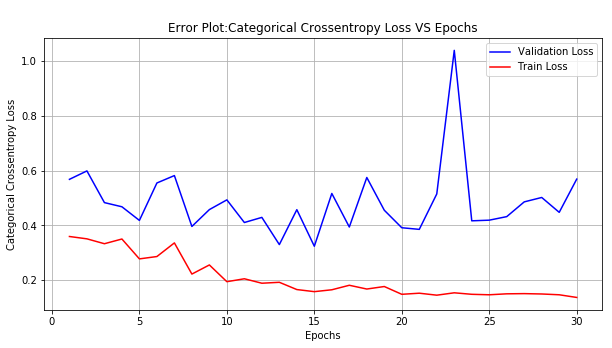

In [31]:
# Evaluating the model
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

# Test and train accuracy of the model
model_test = score[1]
model_train = max(history.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,epochs+1))

# Validation loss
vy = history.history['val_loss']
# Training loss
ty = history.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

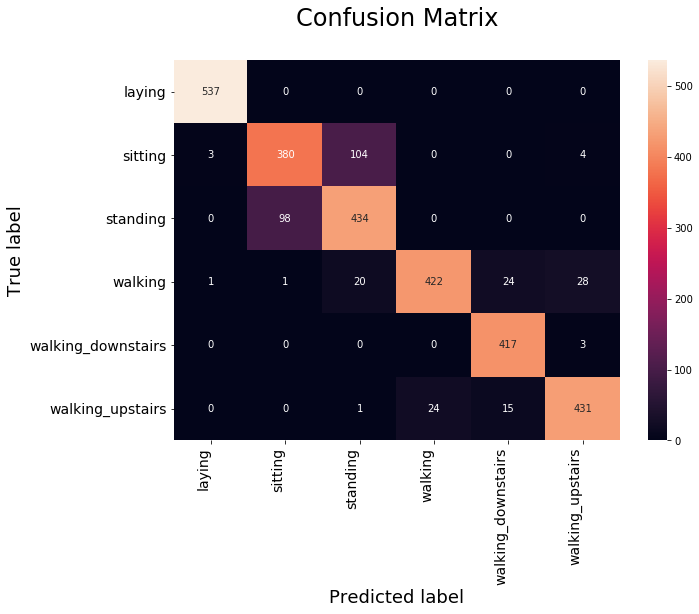

In [32]:
# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

<h2>(2) Model having 1 LSTM layer with 48 LSTM Units and 'adam' as an optimizer</h2>

In [33]:
# Initiliazing the sequential model
model1 = Sequential()
# Configuring the parameters
model1.add(LSTM(48, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model1.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model1.add(Dense(n_classes, activation='sigmoid'))
print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 48)                11136     
_________________________________________________________________
dropout_2 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 294       
Total params: 11,430
Trainable params: 11,430
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
# Compiling the model
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Training the model
history1 = model1.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 60s 8ms/step - loss: 1.4258 - acc: 0.3664 - val_loss: 1.4701 - val_acc: 0.4445
Epoch 2/30
7352/7352 [==============================] - 56s 8ms/step - loss: 1.2538 - acc: 0.4616 - val_loss: 1.1942 - val_acc: 0.4371
Epoch 3/30
7352/7352 [==============================] - 60s 8ms/step - loss: 1.1441 - acc: 0.4891 - val_loss: 1.0569 - val_acc: 0.4768
Epoch 4/30
7352/7352 [==============================] - 64s 9ms/step - loss: 1.2600 - acc: 0.4566 - val_loss: 1.1004 - val_acc: 0.5087
Epoch 5/30
7352/7352 [==============================] - 66s 9ms/step - loss: 1.1449 - acc: 0.5122 - val_loss: 1.2484 - val_acc: 0.3902
Epoch 6/30
7352/7352 [==============================] - 63s 9ms/step - loss: 1.1937 - acc: 0.4116 - val_loss: 1.2153 - val_acc: 0.3546
Epoch 7/30
7352/7352 [==============================] - 61s 8ms/step - loss: 1.1053 - acc: 0.4717 - val_loss: 1.1595 - val_acc: 0.4761
Epoch 8

Test score: 0.4245322878467925
Test accuracy: 87.58059043094673


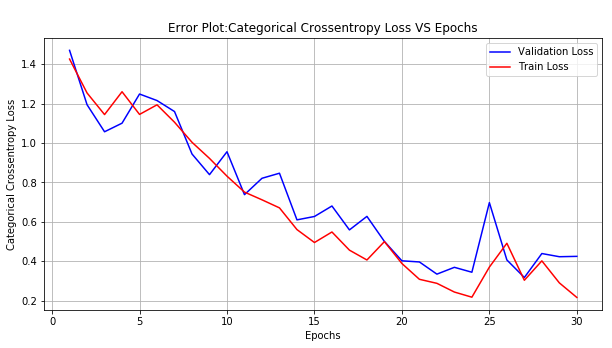

In [37]:
# Evaluating the model
scores1 = model1.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', scores1[0]) 
print('Test accuracy:', scores1[1]*100)

# Test and train accuracy of the model
model_test = scores1[1]
model_train = max(history1.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,epochs+1))

# Validation loss
vy = history1.history['val_loss']
# Training loss
ty = history1.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

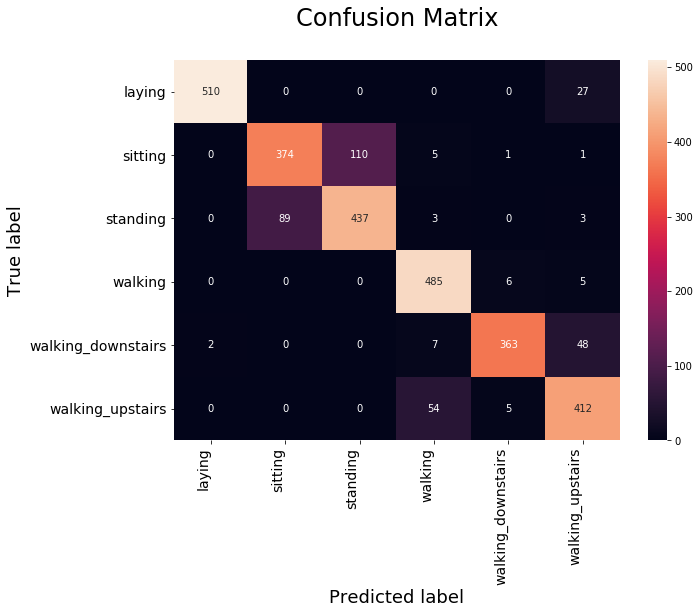

In [38]:
# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model1.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

<h2>(3) Model having 1 LSTM layer with 48 LSTM Units and 'rmsprop' as an optimizer</h2>

In [39]:
# Initiliazing the sequential model
model2 = Sequential()
# Configuring the parameters
model2.add(LSTM(48, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model2.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model2.add(Dense(n_classes, activation='sigmoid'))
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 48)                11136     
_________________________________________________________________
dropout_3 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 294       
Total params: 11,430
Trainable params: 11,430
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
# Compiling the model
model2.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history2 = model2.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 60s 8ms/step - loss: 1.2713 - acc: 0.4533 - val_loss: 1.0970 - val_acc: 0.5049
Epoch 2/30
7352/7352 [==============================] - 56s 8ms/step - loss: 0.9240 - acc: 0.5994 - val_loss: 1.2957 - val_acc: 0.5290
Epoch 3/30
7352/7352 [==============================] - 56s 8ms/step - loss: 0.7256 - acc: 0.6605 - val_loss: 0.7107 - val_acc: 0.6118
Epoch 4/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.6657 - acc: 0.6802 - val_loss: 0.6629 - val_acc: 0.7167
Epoch 5/30
7352/7352 [==============================] - 65s 9ms/step - loss: 0.6044 - acc: 0.7428 - val_loss: 0.5982 - val_acc: 0.7550
Epoch 6/30
7352/7352 [==============================] - 62s 8ms/step - loss: 0.4759 - acc: 0.7980 - val_loss: 0.5205 - val_acc: 0.7849
Epoch 7/30
7352/7352 [==============================] - 62s 8ms/step - loss: 0.3899 - acc: 0.8659 - val_loss: 0.4575 - val_acc: 0.8578
Epoch 8

Test score: 0.4003574819361874
Test accuracy: 91.04173736002714


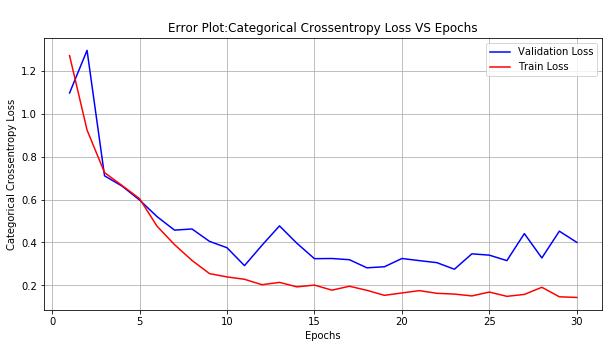

In [43]:
# Evaluating the model
scores2 = model2.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', scores2[0]) 
print('Test accuracy:', scores2[1]*100)

# Test and train accuracy of the model
model_test = scores2[1]
model_train = max(history2.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,epochs+1))

# Validation loss
vy = history2.history['val_loss']
# Training loss
ty = history2.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

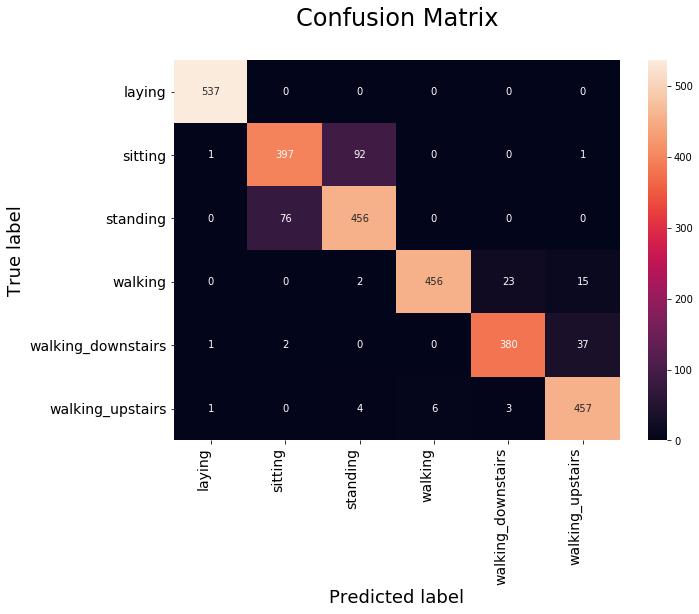

In [44]:
# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model2.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

<h2>(4) Model having 1 LSTM layer with 64 LSTM Units and 'rmsprop' as an optimizer</h2>

In [45]:
# Initiliazing the sequential model
model3 = Sequential()
# Configuring the parameters
model3.add(LSTM(64, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model3.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model3.add(Dense(n_classes, activation='sigmoid'))
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
# Compiling the model
model3.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history3 = model3.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 68s 9ms/step - loss: 1.3051 - acc: 0.4193 - val_loss: 1.5232 - val_acc: 0.4106
Epoch 2/30
7352/7352 [==============================] - 69s 9ms/step - loss: 1.1323 - acc: 0.4736 - val_loss: 1.0354 - val_acc: 0.5137
Epoch 3/30
7352/7352 [==============================] - 66s 9ms/step - loss: 0.9310 - acc: 0.5895 - val_loss: 0.8261 - val_acc: 0.6875
Epoch 4/30
7352/7352 [==============================] - 67s 9ms/step - loss: 0.6725 - acc: 0.7360 - val_loss: 1.2499 - val_acc: 0.6206
Epoch 5/30
7352/7352 [==============================] - 73s 10ms/step - loss: 0.4722 - acc: 0.8303 - val_loss: 0.7451 - val_acc: 0.7933
Epoch 6/30
7352/7352 [==============================] - 67s 9ms/step - loss: 0.3815 - acc: 0.8755 - val_loss: 0.5343 - val_acc: 0.8436
Epoch 7/30
7352/7352 [==============================] - 64s 9ms/step - loss: 0.3248 - acc: 0.8920 - val_loss: 0.5074 - val_acc: 0.8449
Epoch 

Test score: 0.41442884364409954
Test accuracy: 89.82015609093995


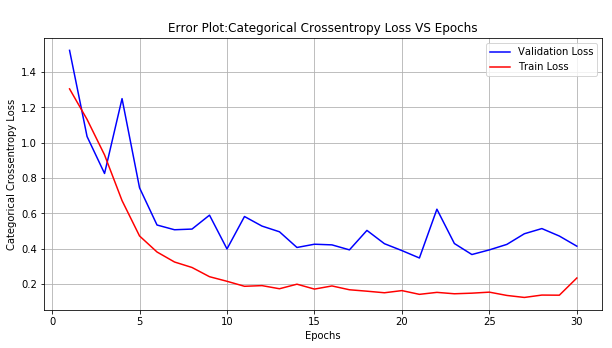

In [48]:
# Evaluating the model
scores3 = model3.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', scores3[0]) 
print('Test accuracy:', scores3[1]*100)

# Test and train accuracy of the model
model_test = scores3[1]
model_train = max(history3.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,epochs+1))

# Validation loss
vy = history3.history['val_loss']
# Training loss
ty = history3.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

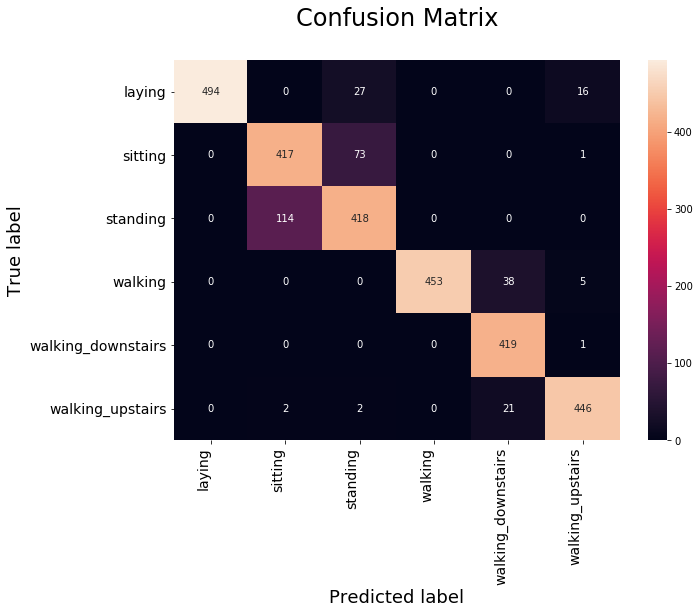

In [49]:
# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model3.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

<h2>(5) Model having 2 LSTM layer with 32 LSTM Units and 'rmsprop' as an optimizer</h2>

In [50]:
# Initiliazing the sequential model
model4 = Sequential()
# Configuring the parameters
model4.add(LSTM(32,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model4.add(Dropout(0.5))

# Configuring the parameters
model4.add(LSTM(32))
# Adding a dropout layer
model4.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model4.add(Dense(n_classes, activation='sigmoid'))
print(model4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________
None


In [51]:
# Compiling the model
model4.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history4 = model4.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 116s 16ms/step - loss: 1.1630 - acc: 0.5200 - val_loss: 0.8542 - val_acc: 0.6159
Epoch 2/30
7352/7352 [==============================] - 109s 15ms/step - loss: 0.7857 - acc: 0.6351 - val_loss: 0.8258 - val_acc: 0.6352
Epoch 3/30
7352/7352 [==============================] - 120s 16ms/step - loss: 0.7234 - acc: 0.6658 - val_loss: 0.7212 - val_acc: 0.6624
Epoch 4/30
7352/7352 [==============================] - 129s 18ms/step - loss: 0.6498 - acc: 0.6927 - val_loss: 0.6450 - val_acc: 0.6742
Epoch 5/30
7352/7352 [==============================] - 121s 17ms/step - loss: 0.5905 - acc: 0.7323 - val_loss: 0.6916 - val_acc: 0.7072
Epoch 6/30
7352/7352 [==============================] - 114s 15ms/step - loss: 0.5037 - acc: 0.7767 - val_loss: 0.5080 - val_acc: 0.7635
Epoch 7/30
7352/7352 [==============================] - 114s 15ms/step - loss: 0.4427 - acc: 0.7996 - val_loss: 0.4929 - val_acc: 

Test score: 0.40523465801943487
Test accuracy: 90.60061079063453


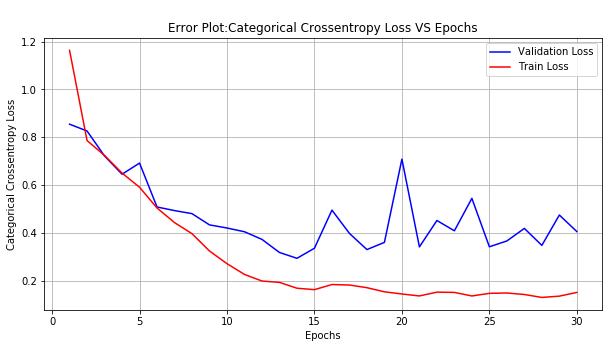

In [53]:
# Evaluating the model
scores4 = model4.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', scores4[0]) 
print('Test accuracy:', scores4[1]*100)

# Test and train accuracy of the model
model_test = scores4[1]
model_train = max(history4.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,epochs+1))

# Validation loss
vy = history4.history['val_loss']
# Training loss
ty = history4.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

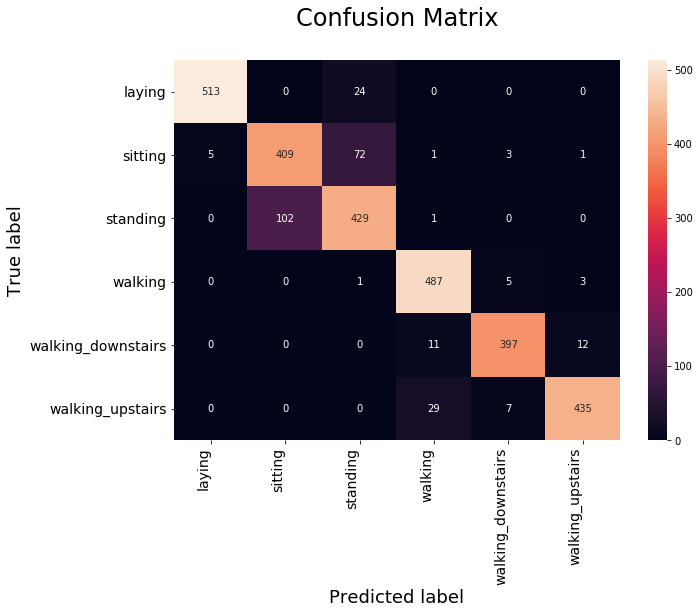

In [54]:
# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model4.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

<h2>(6) Model having 2 LSTM layer with 48 LSTM Units and 'rmsprop' as an optimizer</h2>

In [55]:
# Initiliazing the sequential model
model5 = Sequential()
# Configuring the parameters
model5.add(LSTM(48,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model5.add(Dropout(0.5))

# Configuring the parameters
model5.add(LSTM(48))
# Adding a dropout layer
model5.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model5.add(Dense(n_classes, activation='sigmoid'))
print(model5.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128, 48)           11136     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128, 48)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 48)                18624     
_________________________________________________________________
dropout_8 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 294       
Total params: 30,054
Trainable params: 30,054
Non-trainable params: 0
_________________________________________________________________
None


In [56]:
# Compiling the model
model5.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history5 = model5.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 132s 18ms/step - loss: 1.0838 - acc: 0.5422 - val_loss: 0.8681 - val_acc: 0.6247
Epoch 2/30
7352/7352 [==============================] - 137s 19ms/step - loss: 0.8149 - acc: 0.6356 - val_loss: 1.0262 - val_acc: 0.6227
Epoch 3/30
7352/7352 [==============================] - 141s 19ms/step - loss: 0.6728 - acc: 0.6881 - val_loss: 0.6775 - val_acc: 0.7177
Epoch 4/30
7352/7352 [==============================] - 149s 20ms/step - loss: 0.5931 - acc: 0.7454 - val_loss: 0.6401 - val_acc: 0.7346
Epoch 5/30
7352/7352 [==============================] - 137s 19ms/step - loss: 0.4948 - acc: 0.7775 - val_loss: 0.5848 - val_acc: 0.7550
Epoch 6/30
7352/7352 [==============================] - 144s 20ms/step - loss: 0.4124 - acc: 0.8222 - val_loss: 0.4942 - val_acc: 0.8487
Epoch 7/30
7352/7352 [==============================] - 142s 19ms/step - loss: 0.3589 - acc: 0.8980 - val_loss: 0.4786 - val_acc: 

Test score: 0.5370658709517718
Test accuracy: 90.02375296912113


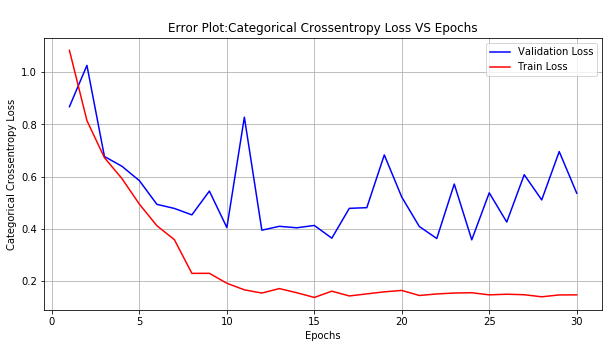

In [57]:
# Evaluating the model
scores5 = model5.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', scores5[0]) 
print('Test accuracy:', scores5[1]*100)

# Test and train accuracy of the model
model_test = scores5[1]
model_train = max(history5.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,epochs+1))

# Validation loss
vy = history5.history['val_loss']
# Training loss
ty = history5.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

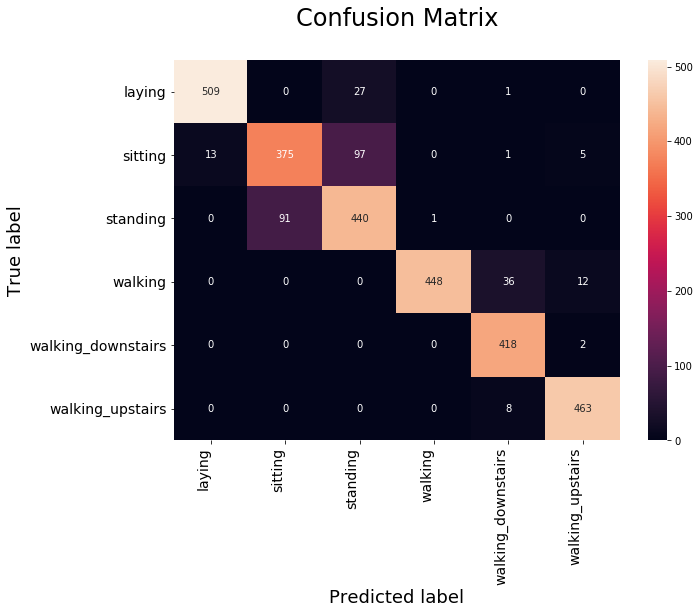

In [58]:
# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model5.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

<h2>(7) Model having 2 LSTM layer with 64 LSTM Units and 'rmsprop' as an optimizer</h2>

In [32]:
# Initiliazing the sequential model
model6 = Sequential()
# Configuring the parameters
model6.add(LSTM(256,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model6.add(Dropout(1.2))

# Configuring the parameters
model6.add(LSTM(256))
# Adding a dropout layer
model6.add(Dropout(1.2))
# Adding a dense output layer with sigmoid activation
model6.add(Dense(n_classes, activation='sigmoid'))
print(model6.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 128, 256)          272384    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128, 256)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 1542      
Total params: 799,238
Trainable params: 799,238
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
# Compiling the model
model6.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history6 = model6.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/12
7352/7352 [==============================] - 1085s 148ms/step - loss: 1.0720 - acc: 0.5180 - val_loss: 0.7735 - val_acc: 0.6481
Epoch 2/12
7352/7352 [==============================] - 1000s 136ms/step - loss: 0.5762 - acc: 0.7587 - val_loss: 1.0644 - val_acc: 0.6539
Epoch 3/12
7352/7352 [==============================] - 1151s 157ms/step - loss: 0.3200 - acc: 0.8779 - val_loss: 0.3567 - val_acc: 0.8992
Epoch 4/12
7352/7352 [==============================] - 1153s 157ms/step - loss: 0.2219 - acc: 0.9176 - val_loss: 0.3141 - val_acc: 0.9033
Epoch 5/12
7352/7352 [==============================] - 1058s 144ms/step - loss: 0.1760 - acc: 0.9331 - val_loss: 0.4998 - val_acc: 0.8921
Epoch 6/12
7352/7352 [==============================] - 1096s 149ms/step - loss: 0.1619 - acc: 0.9372 - val_loss: 0.3152 - val_acc: 0.9002
Epoch 7/12
7352/7352 [==============================] - 865s 118ms/step - loss: 0.1630 - acc: 0.9429 - val_loss: 0.431

Test score: 0.2856981958784459
Test accuracy: 92.16152019002375


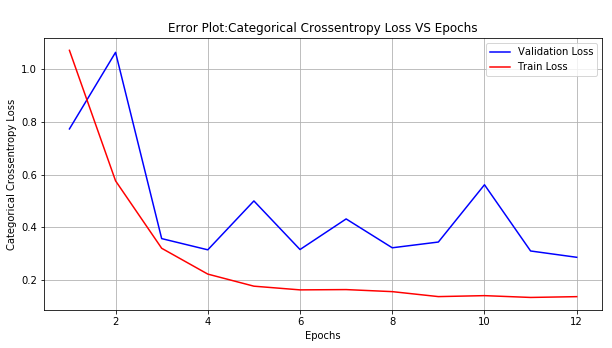

In [37]:
# Evaluating the model
scores6 = model6.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', scores6[0]) 
print('Test accuracy:', scores6[1]*100)

# Test and train accuracy of the model
model_test = scores6[1]
model_train = max(history6.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,epochs+1))

# Validation loss
vy = history6.history['val_loss']
# Training loss
ty = history6.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

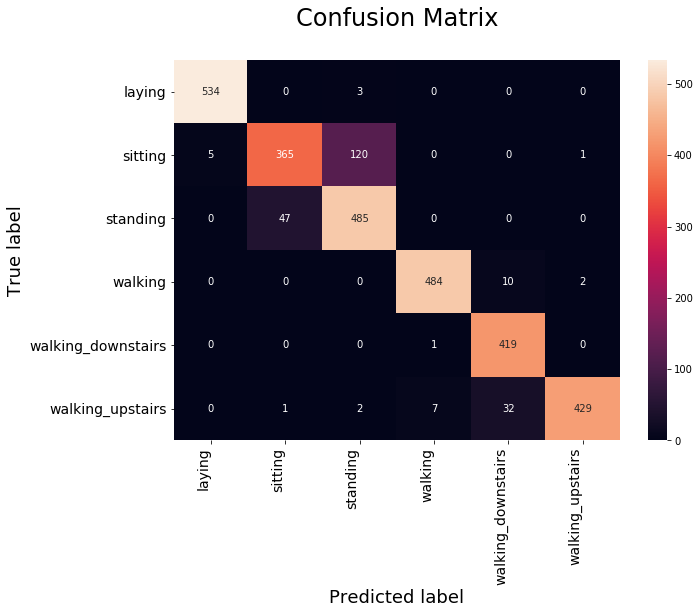

In [38]:
# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model6.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [59]:
# Initiliazing the sequential model
model6 = Sequential()
# Configuring the parameters
model6.add(LSTM(64,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model6.add(Dropout(0.7))

# Configuring the parameters
model6.add(LSTM(64))
# Adding a dropout layer
model6.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model6.add(Dense(n_classes, activation='sigmoid'))
print(model6.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 390       
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
# Compiling the model
model6.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history6 = model6.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 154s 21ms/step - loss: 1.1894 - acc: 0.4890 - val_loss: 0.9152 - val_acc: 0.5514
Epoch 2/30
7352/7352 [==============================] - 144s 20ms/step - loss: 0.7893 - acc: 0.6202 - val_loss: 0.7749 - val_acc: 0.6179
Epoch 3/30
7352/7352 [==============================] - 146s 20ms/step - loss: 0.6631 - acc: 0.6655 - val_loss: 0.6980 - val_acc: 0.6135
Epoch 4/30
7352/7352 [==============================] - 146s 20ms/step - loss: 0.5351 - acc: 0.7718 - val_loss: 0.5402 - val_acc: 0.8324
Epoch 5/30
7352/7352 [==============================] - 145s 20ms/step - loss: 0.3321 - acc: 0.9052 - val_loss: 0.4508 - val_acc: 0.8629
Epoch 6/30
7352/7352 [==============================] - 145s 20ms/step - loss: 0.2572 - acc: 0.9227 - val_loss: 0.5169 - val_acc: 0.8599
Epoch 7/30
7352/7352 [==============================] - 147s 20ms/step - loss: 0.2985 - acc: 0.9170 - val_loss: 0.4529 - val_acc: 

Test score: 0.5657083233671251
Test accuracy: 90.29521547336275


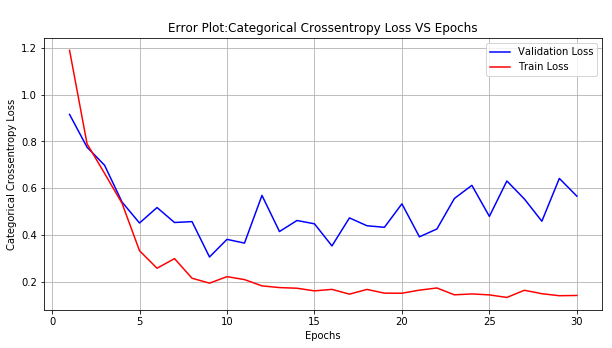

In [61]:
# Evaluating the model
scores6 = model6.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', scores6[0]) 
print('Test accuracy:', scores6[1]*100)

# Test and train accuracy of the model
model_test = scores6[1]
model_train = max(history6.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,epochs+1))

# Validation loss
vy = history6.history['val_loss']
# Training loss
ty = history6.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

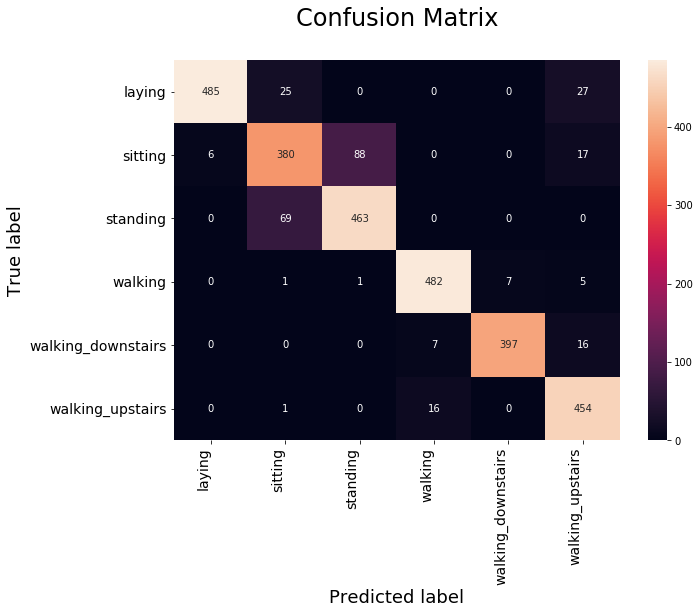

In [62]:
# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model6.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

- Defining the Architecture of CNN

In [73]:
# Importing libraries For CNN
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras import backend as K
from keras.initializers import he_normal
from keras.layers.normalization import BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

batch_size = 128
num_classes = 6
epochs = 24

<h2>(1). CNN with 1 Convolutional layers and kernel size - (4)</h2>

In [120]:
# Initialising the model
model = Sequential()

# Adding first conv layer
model.add(Conv1D(128, kernel_size=(4),activation='relu',input_shape=(timesteps, input_dim)))

# Adding Maxpooling layer
model.add(MaxPooling1D(pool_size=(2)))

# Adding Dropout
model.add(Dropout(0.7))

# Adding flatten layer
model.add(Flatten())

# Adding first hidden layer
model.add(Dense(256, activation='relu',kernel_initializer=he_normal(seed=None)))

# Adding Dropout
model.add(Dropout(0.7))

# Adding output layer
model.add(Dense(num_classes, activation='softmax'))

# Printing model Summary
print(model.summary())

# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fitting the data to the model
history = model.fit(X_train, Y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_47 (Conv1D)           (None, 125, 128)          4736      
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 62, 128)           0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 62, 128)           0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 7936)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               2031872   
_________________________________________________________________
dropout_46 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 6)                 1542      
Total para

In [130]:
# Evaluating the model
scores = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1]*100)

Test score: 0.0971424736066323
Test accuracy: 96.37914828639295


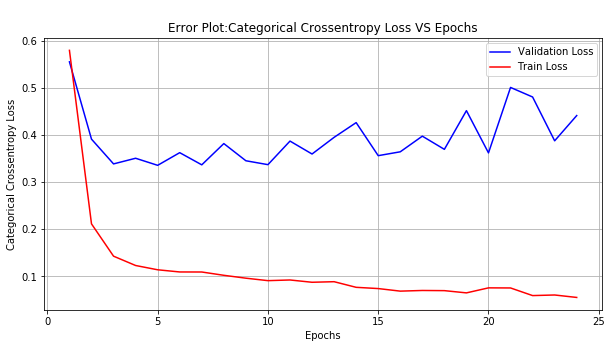

In [123]:
# Test and train accuracy of the model
model_test = scores[1]
model_train = max(history.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,epochs+1))

# Validation loss
vy = history.history['val_loss']
# Training loss
ty = history.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

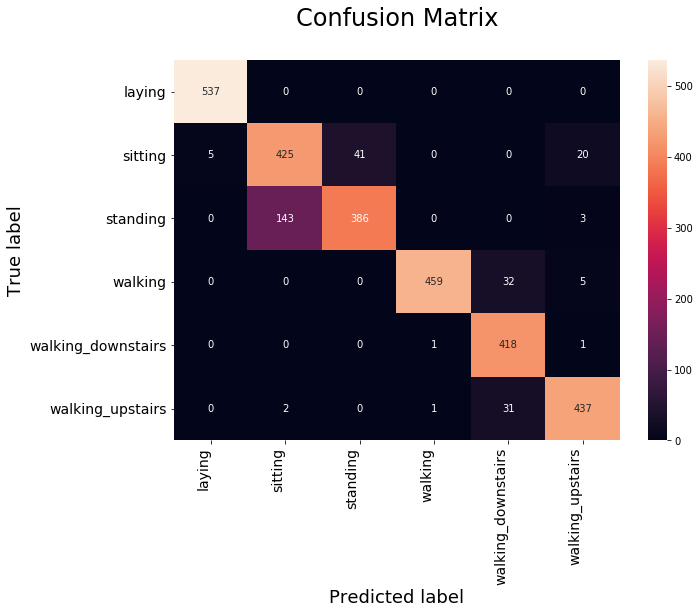

In [124]:
# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [111]:
# Initialising the model
model_1 = Sequential()

# Adding first conv layer
model_1.add(Conv1D(256, kernel_size=(4),activation='relu',input_shape=(timesteps, input_dim)))

# Adding Maxpooling layer
model_1.add(MaxPooling1D(pool_size=(2)))

# Adding Dropout
model_1.add(Dropout(0.7))

# Adding flatten layer
model_1.add(Flatten())

# Adding first hidden layer
model_1.add(Dense(256, activation='relu',kernel_initializer=he_normal(seed=None)))

# Adding Dropout
model_1.add(Dropout(0.7))

# Adding output layer
model_1.add(Dense(num_classes, activation='softmax'))

# Printing model Summary
print(model_1.summary())

# Compiling the model
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fitting the data to the model
history_1 = model_1.fit(X_train, Y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_46 (Conv1D)           (None, 125, 256)          9472      
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 62, 256)           0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 62, 256)           0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 15872)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               4063488   
_________________________________________________________________
dropout_44 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 6)                 1542      
Total para

In [131]:
# Evaluating the model
scores_1 = model_1.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', scores_1[0]) 
print('Test accuracy:', scores_1[1]*100)

Test score: 0.0723338599741028
Test accuracy: 96.73780454699695


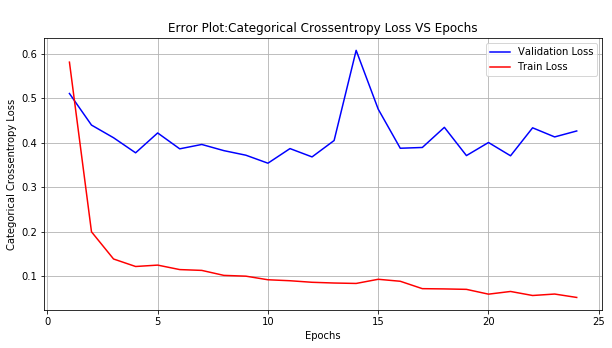

In [113]:
# Test and train accuracy of the model
model_test = scores_1[1]
model_train = max(history_1.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,epochs+1))

# Validation loss
vy = history_1.history['val_loss']
# Training loss
ty = history_1.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

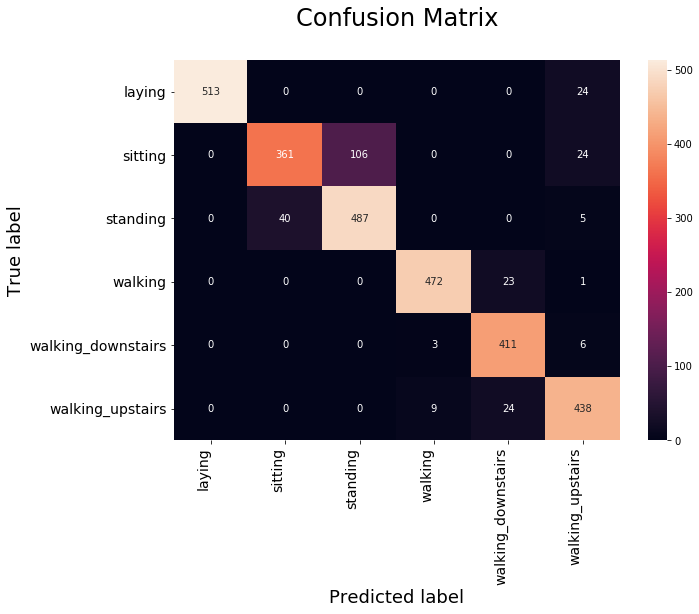

In [114]:
# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model_1.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


<h2>(2). CNN with 3 Convolutional layers and kernel size - (3)</h2>

In [88]:
# Initialising the model
model_2 = Sequential()

# Adding first conv layer
model_2.add(Conv1D(32, kernel_size=(3),activation='relu',input_shape=(timesteps, input_dim)))

# Adding second conv layer
model_2.add(Conv1D(128, (3), activation='relu'))

# Adding Maxpooling layer
model_2.add(MaxPooling1D(pool_size=(2)))

# Adding Dropout
model_2.add(Dropout(0.25))

# Adding third conv layer
model_2.add(Conv1D(256, (3), activation='relu'))

# Adding Maxpooling layer
model_2.add(MaxPooling1D(pool_size=(2)))

# Adding Dropout
model_2.add(Dropout(0.7))

# Adding flatten layer
model_2.add(Flatten())

# Adding first hidden layer
model_2.add(Dense(512, activation='relu',kernel_initializer=he_normal(seed=None)))

# Adding Dropout
model_2.add(Dropout(0.7))

# Adding output layer
model_2.add(Dense(num_classes, activation='softmax'))

# Printing model Summary
print(model_2.summary())

# Compiling the model
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fitting the data to the model
history_2 = model_2.fit(X_train, Y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 126, 32)           896       
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 124, 128)          12416     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 62, 128)           0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 62, 128)           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 60, 256)           98560     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 30, 256)           0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 30, 256)           0         
__________

In [132]:
# Evaluating the model
scores_2 = model_2.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', scores_2[0]) 
print('Test accuracy:', scores_2[1]*100)

Test score: 0.071302715732692
Test accuracy: 96.72476077366812


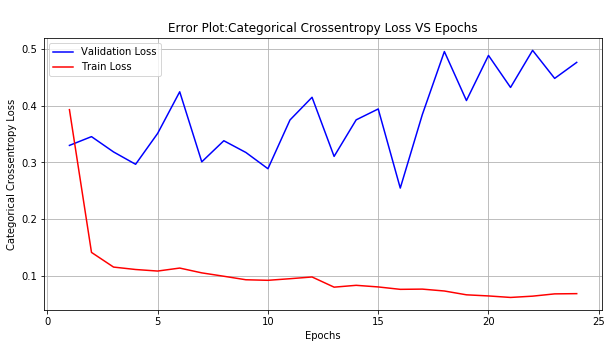

In [101]:
# Test and train accuracy of the model
model_test = scores_2[1]
model_train = max(history_2.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,epochs+1))

# Validation loss
vy = history_3.history['val_loss']
# Training loss
ty = history_3.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

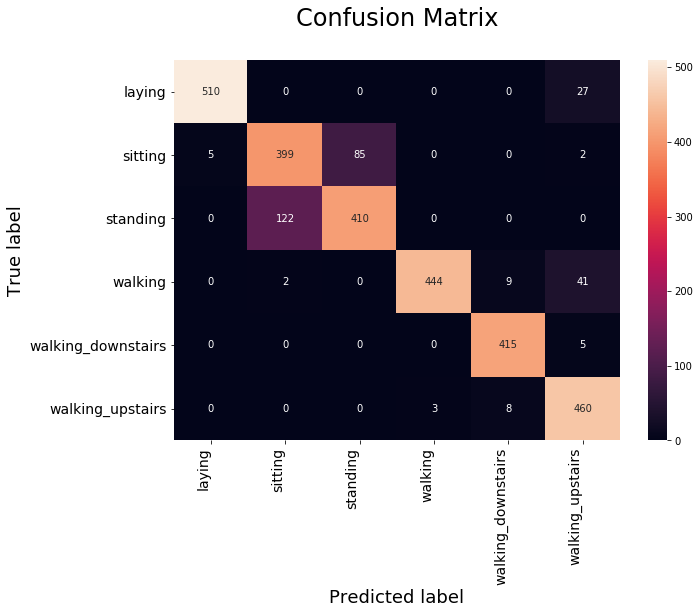

In [96]:
# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model_2.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

<h2>(3). CNN with 5 Convolutional layers and kernel sizea - (5)</h2>

In [97]:
# Initialising the model
model_3 = Sequential()

# Adding first conv layer
model_3.add(Conv1D(16, kernel_size=(5),padding='same',activation='relu',input_shape=(timesteps, input_dim)))

# Adding second conv layer
model_3.add(Conv1D(32, (5), activation='relu'))

# Adding Maxpooling layer
model_3.add(MaxPooling1D(pool_size=(2),padding='same'))

# Adding Dropout
model_3.add(Dropout(0.25))

# Adding third conv layer
model_3.add(Conv1D(64, (5),padding='same', activation='relu'))

# Adding Maxpooling layer
model_3.add(MaxPooling1D(pool_size=(2),padding='same'))

# Adding Dropout
model_3.add(Dropout(0.7))

# Adding fourth conv layer
model_3.add(Conv1D(128, (5),padding='same',activation='relu'))

# Adding fifth conv layer
model_3.add(Conv1D(128, (5), activation='relu'))

# Adding Maxpooling layer
model_3.add(MaxPooling1D(pool_size=(2),padding='same'))

# Adding Dropout
model_3.add(Dropout(0.5))

# Adding flatten layer
model_3.add(Flatten())

# Adding first hidden layer
model_3.add(Dense(512, activation='relu',kernel_initializer=he_normal(seed=None)))

# Adding Batch Normalization
model_3.add(BatchNormalization())

# Adding Dropout
model_3.add(Dropout(0.7))

# Adding output layer
model_3.add(Dense(num_classes, activation='softmax'))

# Printing model Summary
print(model_3.summary())

# Compiling the model
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fitting the data to the model
history_3 = model_3.fit(X_train, Y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 128, 16)           736       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 124, 32)           2592      
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 62, 32)            0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 62, 32)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 62, 64)            10304     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 31, 64)            0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 31, 64)            0         
__________

In [133]:
# Evaluating the model
scores_3 = model_3.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', scores_3[0]) 
print('Test accuracy:', scores_3[1]*100)

Test score: 0.07731656618525826
Test accuracy: 96.70106549032916


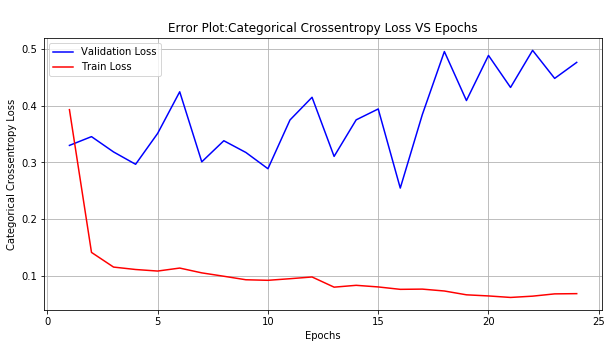

In [102]:
# Test and train accuracy of the model
model_test = scores_3[1]
model_train = max(history_3.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,epochs+1))

# Validation loss
vy = history_3.history['val_loss']
# Training loss
ty = history_3.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

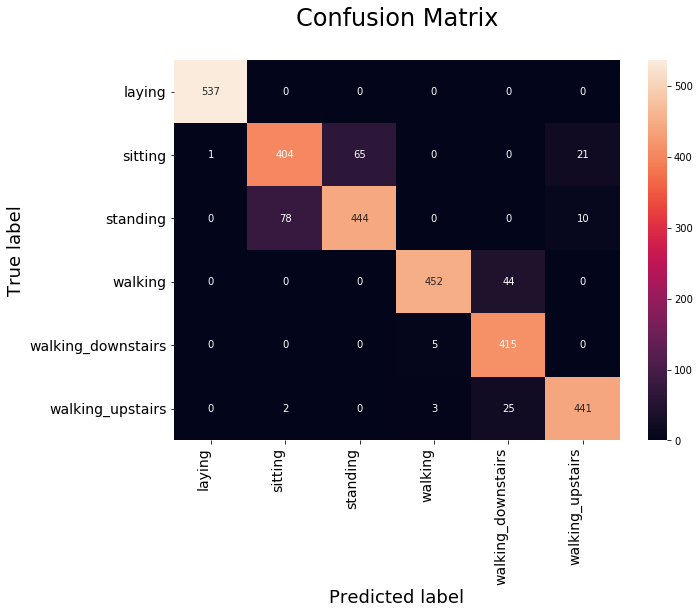

In [103]:
# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model_3.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

<h2>CONCLUSION</h2>

<h2>(a). Table (Model performances) LSTM Architecture:</h2>

In [68]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of models
names =['1 LSTM layer with 32 LSTM Units(Optimizer-->rmsprop)','1 LSTM layer with 48 LSTM Units(Optimizer-->adam)',\
        '1 LSTM layer with 48 LSTM Units(Optimizer-->rmsprop)','1 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop)',\
        '2 LSTM layer with 32 LSTM Units(Optimizer-->rmsprop)','2 LSTM layer with 48 LSTM Units(Optimizer-->rmsprop)',\
        '2 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop)']

# Training accuracies
train_acc = [history.history['acc'][29],history1.history['acc'][29],history2.history['acc'][29],\
             history3.history['acc'][29],history4.history['acc'][29],history5.history['acc'][29],history6.history['acc'][29]]

# Test accuracies
test_acc =[scores[1],scores1[1],scores2[1],scores3[1],scores4[1],scores5[1],scores6[1]]

numbering = [1,2,3,4,5,6,7]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+------------------------------------------------------+--------------------+--------------------+
| S.NO. |                        MODEL                         | Training Accuracy  |   Test Accuracy    |
+-------+------------------------------------------------------+--------------------+--------------------+
|   1   | 1 LSTM layer with 32 LSTM Units(Optimizer-->rmsprop) | 0.9508977149075082 | 0.8893790295215473 |
|   2   |  1 LSTM layer with 48 LSTM Units(Optimizer-->adam)   | 0.9309031556039173 | 0.8758059043094673 |
|   3   | 1 LSTM layer with 48 LSTM Units(Optimizer-->rmsprop) | 0.948721436343852  | 0.9104173736002714 |
|   4   | 1 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop) | 0.9371599564744287 | 0.8982015609093994 |
|   5   | 2 LSTM layer with 32 LSTM Units(Optimizer-->rmsprop) | 0.9519858541893362 | 0.9060061079063454 |
|   6   | 2 LSTM layer with 48 LSTM Units(Optimizer-->rmsprop) | 0.9517138193688792 | 0.9002375296912114 |
|   7   | 2 LSTM layer with 64 LSTM U

<h2> Table (Model performances) CNN Architecture:</h2>

In [140]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of models
names =['CNN with 1 Convolutional layers and kernel size - (4)','CNN with 1 Convolutional layers and kernel size - (4)',\
        'CNN with 3 Convolutional layers and kernel size - (3)','CNN with 5 Convolutional layers and kernel size - (2)']

# Training accuracies
train_acc = [max(history.history['acc']),max(history_1.history['acc']),max(history_2.history['acc']),\
             max(history_3.history['acc'])]

# Test accuracies
test_acc =[scores[1],scores_1[1],scores_2[1],scores_3[1]]

numbering = [1,2,3,4]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+-------------------------------------------------------+--------------------+--------------------+
| S.NO. |                         MODEL                         | Training Accuracy  |   Test Accuracy    |
+-------+-------------------------------------------------------+--------------------+--------------------+
|   1   | CNN with 1 Convolutional layers and kernel size - (4) | 0.9755168662885847 | 0.9637914828639295 |
|   2   | CNN with 1 Convolutional layers and kernel size - (4) | 0.9757889009793254 | 0.9673780454699695 |
|   3   | CNN with 3 Convolutional layers and kernel size - (3) | 0.9764689881601842 | 0.9672476077366812 |
|   4   | CNN with 5 Convolutional layers and kernel size - (2) | 0.9710282916861857 | 0.9670106549032916 |
+-------+-------------------------------------------------------+--------------------+--------------------+


<h2>(b). Procedure Followed :</h2>

STEP 1 :- Loading the data and spliting the dataset into training set and test set

STEP 2:-Trying out different LSTM architectures

STEP 3:- Finding test score and accuracy for each model

Step 4:- Drawing Error Plot.

STEP 5:- Drawing confusion matrix using seaborn heatmap for each model

STEP 6:-Trying out different CNN architectures

STEP 7:- Drawing confusion matrix using seaborn heatmap for each model